In [44]:
import numpy as np
import time
import os
from simsopt.geo.surfacerzfourier import SurfaceRZFourier
from simsopt.geo.curve import create_equally_spaced_curves
from simsopt.geo.curvexyzfourier import CurveXYZFourier
from simsopt.geo.wireframe import ToroidalWireframe, windowpane_wireframe
from simsopt.geo import HBTCylFourier, create_equally_spaced_cylindrical_curves, ToroidalFlux, curves_to_vtk
from simsopt.field.coil import apply_symmetries_to_curves, apply_symmetries_to_currents, coils_via_symmetries, Current, Coil, ScaledCurrent
from simsopt.field.biotsavart import BiotSavart
from simsopt.field.wireframefield import WireframeField, enclosed_current
from simsopt.objectives.fluxobjective import SquaredFlux
from simsopt.solve.wireframe_optimization import optimize_wireframe
from simsopt.geo import CurveCurveDistance, CurveSurfaceDistance
import matplotlib.pylab as plt
from simsopt._core import load

In [45]:
# plasma surface parameters
plas_nPhi = 64
plas_nTheta = 64
surf_s = 1.0
surf_dof_scale = 0.15
# Define a toroidal surface on which the wireframe is to be constructed
VV_a = 0.25
VV_R0 = 1.0

2
1.0008264582599344
0.14912726907888424
6.711223671175287
0.43934192516184023


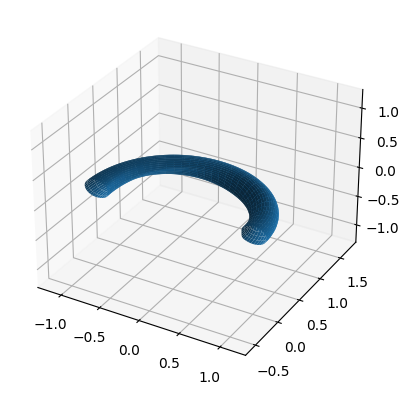

<Axes3D: >

In [46]:
# Import plasma boundary and generate a winding surface for the wireframe
eq_name = 'wout_NAS_n2n4_AR6.2.03'
input_QA = eq_name + '.nc'

surf_nfp1 = SurfaceRZFourier.from_wout(input_QA, surf_s, range='half period', nphi=plas_nPhi, ntheta=plas_nTheta)

surf_plas = SurfaceRZFourier(mpol=surf_nfp1.mpol,ntor=surf_nfp1.ntor,nfp=2,stellsym=True,
                                quadpoints_theta=surf_nfp1.quadpoints_theta,
                                quadpoints_phi=surf_nfp1.quadpoints_phi)
surf_plas.least_squares_fit(surf_nfp1.gamma())
# surf_plas = SurfaceRZFourier.from_wout(input_QA, surf_s, range='half period', nphi=plas_nPhi, ntheta=plas_nTheta)
surf_plas.set_dofs(surf_dof_scale*surf_plas.get_dofs())
surf_plas.set_rc(0,0,VV_R0)

# Geometric properties of the target plasma boundary
n = surf_plas.normal()
absn = np.linalg.norm(n, axis=2)
unitn = n * (1./absn)[:,:,None]
sqrt_area = np.sqrt(absn.reshape((-1,1))/float(absn.size))
surf_area = sqrt_area**2

major_radius = surf_plas.major_radius()
minor_radius = surf_plas.minor_radius()
aspect_ratio = surf_plas.aspect_ratio()
volume = surf_plas.volume()

print(surf_plas.nfp)
print(major_radius)
print(minor_radius)
print(aspect_ratio)
print(volume)
surf_plas.plot(close=True)

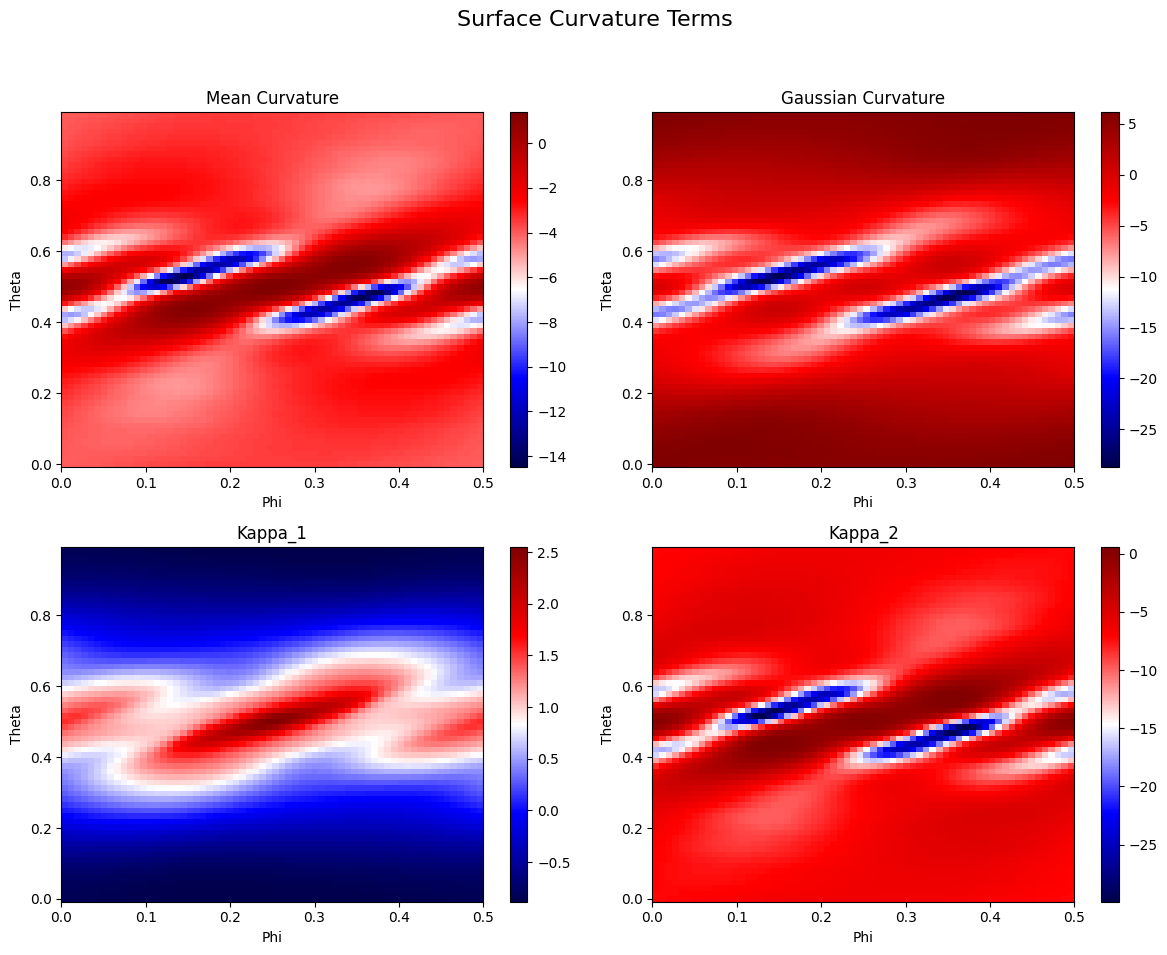

In [91]:
surface_curvatures = surf_plas.surface_curvatures()
nphi,ntheta,_ = surf_plas.gamma().shape
theta = surf_plas.quadpoints_theta # note, these go from 0 to 1
phi = surf_plas.quadpoints_phi
Phi, Theta = np.meshgrid(phi, theta)
# Extract each 64x64 array from the 64x64x4 array
mean_curvature = np.transpose(surface_curvatures[:, :, 0].reshape((nphi,ntheta)))
gaussian_curvature = np.transpose(surface_curvatures[:, :, 1].reshape((nphi,ntheta)))
kappa_1 = np.transpose(surface_curvatures[:, :, 2].reshape((nphi,ntheta)))
kappa_2 = np.transpose(surface_curvatures[:, :, 3].reshape((nphi,ntheta)))

# Create a figure and a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define titles for each subplot
titles = ['Mean Curvature', 'Gaussian Curvature', 'Kappa_1', 'Kappa_2']
data = [mean_curvature, gaussian_curvature, kappa_1, kappa_2]

# Plot each 64x64 array in the subplots
for ax, title, datum in zip(axes.flat, titles, data):
    #norm = TwoSlopeNorm(vmin=datum.min(), vcenter=0, vmax=datum.max())
    cax = ax.pcolormesh(Phi, Theta, datum, cmap='seismic', shading='auto')
    ax.set_title(title)
    ax.set_xlabel('Phi')
    ax.set_ylabel('Theta')
    fig.colorbar(cax, ax=ax)

# Set the main title for the entire plot
fig.suptitle('Surface Curvature Terms', fontsize=16)

# Adjust layout to make space for the main title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

In [92]:
rad_circ = 100 / np.max([np.max(np.abs(kappa_1)), np.max(np.abs(kappa_2))])
print(f"minimum surface radius of curvature = {rad_circ:.2f} [cm]")

minimum surface radius of curvature = 3.34 [cm]


In [93]:
print(kappa_1)

[[-0.8403576  -0.84076831 -0.8415827  ... -0.8415827  -0.84076831
  -0.8403576 ]
 [-0.83637671 -0.83712717 -0.83829996 ... -0.836677   -0.83615823
  -0.83605459]
 [-0.82427651 -0.8253631  -0.8269074  ... -0.82377689 -0.82349289
  -0.82365455]
 ...
 [-0.80349837 -0.80315684 -0.80328763 ... -0.80746867 -0.80565468
  -0.80432909]
 [-0.82365455 -0.82349289 -0.82377689 ... -0.8269074  -0.8253631
  -0.82427651]
 [-0.83605459 -0.83615823 -0.836677   ... -0.83829996 -0.83712717
  -0.83637671]]


In [98]:
kappa_1_new = np.zeros([64, 64, 1])
kappa_1_new[:,:,0] = np.transpose(kappa_1)
kappa_2_new = np.zeros([64, 64, 1])
kappa_2_new[:,:,0] = np.transpose(kappa_2)
gaussian_curvature_new = np.zeros([64, 64, 1])
gaussian_curvature_new[:,:,0] = np.transpose(gaussian_curvature)
mean_curvature_new = np.zeros([64, 64, 1])
mean_curvature_new[:,:,0] = np.transpose(mean_curvature)

In [99]:
os.makedirs(eq_name, exist_ok=True)
surf_plas.to_vtk(f'{eq_name}/surf_plas_k1', extra_data={"kappa_1": kappa_1_new})
surf_plas.to_vtk(f'{eq_name}/surf_plas_k2', extra_data={"kappa_2": kappa_2_new})
surf_plas.to_vtk(f'{eq_name}/surf_plas_G', extra_data={"gaussian": gaussian_curvature_new})
surf_plas.to_vtk(f'{eq_name}/surf_plas_H', extra_data={"mean": mean_curvature_new})